##### 三类股票分类，
##### 使用未来三天的平均change来作为标签值y，并用0.33, 0.67分位值作为三类标签的划分边界

##### 数据: 基本指标 
##### 模型:  LSTM


In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import row_stack,column_stack
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY,YEARLY
# from mpl_finance import quotes_historical_yahoo_ohlc, candlestick_ohlc
from matplotlib.pylab import date2num
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation,Dropout
import tushare as ts
import datetime
import time

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### softmax三类分类写不出来，用回归代替

### 加工数据

In [2]:
ts.set_token('29ea8fa19e717f1a3d3618796f87067ee07219783a9e01422eb90ef8')
pro = ts.pro_api()

# df = ts.get_hist_data('601318',start='2009-01-01',end='2018-01-12') #一次性获取全部日k线数据
df = pro.daily(ts_code='000002.SZ', start_date = '20110701', end_date = '20181118')
df = df.iloc[::-1]
df.head()

df.to_csv('Vanke-from-20110701-to-20181118.csv', index=False)

df = pd.read_csv('Vanke-from-20110701-to-20181118.csv')
df.head()

# input_data = df[['open','high','low','pre_close','change','pct_change','vol','amount','close']]


,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000002.SZ,20110701,8.43,8.81,8.40,8.68,8.45,0.23,2.72,1277998.67,1.105772e+06
1,000002.SZ,20110704,8.73,8.97,8.68,8.71,8.68,0.03,0.35,832629.39,7.328196e+05
2,000002.SZ,20110705,8.71,9.02,8.71,8.84,8.71,0.13,1.49,1470530.64,1.307364e+06
3,000002.SZ,20110706,8.85,8.88,8.71,8.82,8.84,-0.02,-0.23,609540.69,5.355945e+05
4,000002.SZ,20110707,8.84,8.98,8.55,8.77,8.82,-0.05,-0.57,846650.10,7.444219e+05


In [3]:
df.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000002.SZ,20110701,8.43,8.81,8.40,8.68,8.45,0.23,2.72,1277998.67,1.105772e+06
1,000002.SZ,20110704,8.73,8.97,8.68,8.71,8.68,0.03,0.35,832629.39,7.328196e+05
2,000002.SZ,20110705,8.71,9.02,8.71,8.84,8.71,0.13,1.49,1470530.64,1.307364e+06
3,000002.SZ,20110706,8.85,8.88,8.71,8.82,8.84,-0.02,-0.23,609540.69,5.355945e+05
4,000002.SZ,20110707,8.84,8.98,8.55,8.77,8.82,-0.05,-0.57,846650.10,7.444219e+05


In [4]:
df_ashare = pro.index_daily(ts_code='000001.SH',start_date = '20110701', end_date = '20181118')
df_ashare = df_ashare.iloc[::-1]
df_ashare.head()
df_ashare.to_csv('Ashare-from-20110701-to-20181118.csv', index=False)

df_ashare = pd.read_csv('Ashare-from-20110701-to-20181118.csv')
df_ashare.head()

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,000001.SH,20110701,2759.362,2767.834,2778.668,2752.966,2762.076,-2.714,-0.0983,92072878.0,1.054532e+08
1,000001.SH,20110704,2812.818,2770.940,2813.270,2770.940,2759.362,53.456,1.9373,121962260.0,1.438187e+08
2,000001.SH,20110705,2816.355,2812.722,2818.141,2799.110,2812.818,3.537,0.1257,110124224.0,1.286545e+08
3,000001.SH,20110706,2810.479,2811.815,2811.815,2780.728,2816.355,-5.876,-0.2086,103104393.0,1.220889e+08
4,000001.SH,20110707,2794.267,2813.193,2825.123,2793.892,2810.479,-16.212,-0.5768,116512143.0,1.400651e+08


In [5]:
# new_data = pd.merge(df, df_ashare, left_on='trade_date')
new_data = pd.merge(df, df_ashare, how='outer', on='trade_date')


In [6]:
new_data = new_data.dropna(how='any') 

In [7]:
len(df), len(df_ashare), len(new_data)

(1645, 1796, 1645)

In [8]:
new_data.fillna(0 , inplace=True)

In [9]:
input_data = new_data.drop(['trade_date','ts_code_x','ts_code_y'], axis=1)

In [10]:
# temp_df = input_data.pop('ave_change')
# input_data['ave_change'] = temp_df
# input_data.head()
quantile033 = input_data['change_x'].quantile([0.33]).iloc[0]
quantile067 = input_data['change_x'].quantile([0.67]).iloc[0]
change = input_data['change_x']
ave_change_column = [ ]
for i in range(0, len(change)):
    if i >= len(change) - 3:
        ave_change = change[i]
        
    else:
        ave_change = (change[i+1] + change[i+2] + change[i+3]) / 3
    
    ave_change_column.append(ave_change)

input_data['ave_change'] = ave_change_column

In [11]:
#获得合并后的数据
input_data.head()

,open_x,high_x,low_x,close_x,pre_close_x,change_x,pct_chg_x,vol_x,amount_x,close_y,open_y,high_y,low_y,pre_close_y,change_y,pct_chg_y,vol_y,amount_y,ave_change
0,8.43,8.81,8.40,8.68,8.45,0.23,2.72,1277998.67,1.105772e+06,2759.362,2767.834,2778.668,2752.966,2762.076,-2.714,-0.0983,92072878.0,1.054532e+08,0.046667
1,8.73,8.97,8.68,8.71,8.68,0.03,0.35,832629.39,7.328196e+05,2812.818,2770.940,2813.270,2770.940,2759.362,53.456,1.9373,121962260.0,1.438187e+08,0.020000
2,8.71,9.02,8.71,8.84,8.71,0.13,1.49,1470530.64,1.307364e+06,2816.355,2812.722,2818.141,2799.110,2812.818,3.537,0.1257,110124224.0,1.286545e+08,-0.006667
3,8.85,8.88,8.71,8.82,8.84,-0.02,-0.23,609540.69,5.355945e+05,2810.479,2811.815,2811.815,2780.728,2816.355,-5.876,-0.2086,103104393.0,1.220889e+08,-0.023333
4,8.84,8.98,8.55,8.77,8.82,-0.05,-0.57,846650.10,7.444219e+05,2794.267,2813.193,2825.123,2793.892,2810.479,-16.212,-0.5768,116512143.0,1.400651e+08,-0.090000


In [12]:
data = input_data.values

dd1=input_data.sort_index()

dd2=dd1.values.flatten()

dd3=pd.DataFrame(dd1['close_x'])

In [13]:
def load_data(df, sequence_length=10, split=0.8):
    # 转为float型
    data_all = np.array(df.astype(float))
    # 标准化
    x_scaler = MinMaxScaler()
    data_all[:, :-1] = x_scaler.fit_transform(data_all[:, :-1])
    data = []
    for i in range(len(data_all) - sequence_length - 1):
        data.append(data_all[i: i + sequence_length + 1])
    reshaped_data = np.array(data).astype('float64')
    x = reshaped_data[:, :-1]
    y = reshaped_data[:, -1][:, -1]
    scaler = MinMaxScaler()
    y = scaler.fit_transform(y.reshape(-1, 1))
    split_boundary = int(reshaped_data.shape[0] * split)
    train_x = x[: split_boundary]
    test_x = x[split_boundary:]

    train_y = y[: split_boundary]
    test_y = y[split_boundary:]

    return train_x, train_y, test_x, test_y, scaler

In [14]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.4))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [15]:
def train_model(train_x, train_y, test_x, test_y):
    model = build_model([train_x.shape[2], train_x.shape[1], 200, 1])

    try:
        model.fit(train_x, train_y, batch_size=40, nb_epoch=200, validation_split=0.1)
        predict = model.predict(test_x)
        predict = np.reshape(predict, (predict.size, ))
    except KeyboardInterrupt:
        print(predict)
        print(test_y)
#     print(predict)
#     print(test_y)
    try:
        fig = plt.figure(1)
        plt.plot(predict, 'r:')
        plt.plot(test_y, 'g-')
        plt.legend(['predict', 'true'])
    except Exception as e:
        print(e)
    return predict, test_y , model

In [16]:
train_x, train_y, test_x, test_y, scaler =load_data(dd1, sequence_length=10, split=0.8)

In [17]:
print("train_x", train_x.shape)
print("train_y", train_y.shape)
print("test_x", test_x.shape)
print("test_y", test_y.shape)

train_x (1307, 10, 19)
train_y (1307, 1)
test_x (327, 10, 19)
test_y (327, 1)


d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 19), units=10)`
  
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Compilation Time :  0.028943300247192383
Train on 1176 samples, validate on 131 samples
Epoch 1/200
1176/1176 [==============================] - 3s 2ms/step - loss: 0.0179 - acc: 8.5034e-04 - val_loss: 0.0056 - val_acc: 0.0000e+00
Epoch 2/200
1176/1176 [==============================] - 1s 871us/step - loss: 0.0076 - acc: 0.0017 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 3/200
1176/1176 [==============================] - 1s 839us/step - loss: 0.0067 - acc: 0.0017 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 4/200
1176/1176 [==============================] - 1s 837us/step - loss: 0.0068 - acc: 8.5034e-04 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 5/200
1176/1176 [==============================] - 1s 827us/step - loss: 0.0062 - acc: 8.5034e-04 - val_loss: 0.0061 - val_acc: 0.0000e+00
Epoch 6/200
1176/1176 [==============================] - 1s 869us/step - loss: 0.0057 - acc: 8.5034e-04 - val_loss: 0.0143 - val_acc: 0.0000e+00
Epoch 7/200
1176/1176 [=============================

Epoch 114/200
1176/1176 [==============================] - 1s 776us/step - loss: 0.0015 - acc: 0.0017 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 115/200
1176/1176 [==============================] - 1s 799us/step - loss: 0.0015 - acc: 0.0017 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 116/200
1176/1176 [==============================] - 1s 731us/step - loss: 0.0015 - acc: 0.0017 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 117/200
1176/1176 [==============================] - 1s 798us/step - loss: 0.0015 - acc: 0.0017 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 118/200
1176/1176 [==============================] - 1s 770us/step - loss: 0.0014 - acc: 0.0017 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 119/200
1176/1176 [==============================] - 1s 811us/step - loss: 0.0015 - acc: 0.0017 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 120/200
1176/1176 [==============================] - 1s 761us/step - loss: 0.0015 - acc: 0.0017 - val_loss: 0.0020 - val_acc: 0.0000e+00

Epoch 171/200
1176/1176 [==============================] - 1s 742us/step - loss: 0.0014 - acc: 0.0017 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 172/200
1176/1176 [==============================] - 1s 778us/step - loss: 0.0014 - acc: 0.0017 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 173/200
1176/1176 [==============================] - 1s 790us/step - loss: 0.0013 - acc: 0.0017 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 174/200
1176/1176 [==============================] - 1s 752us/step - loss: 0.0013 - acc: 0.0017 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 175/200
1176/1176 [==============================] - 1s 746us/step - loss: 0.0012 - acc: 0.0017 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 176/200
1176/1176 [==============================] - 1s 817us/step - loss: 0.0014 - acc: 0.0017 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 177/200
1176/1176 [==============================] - 1s 779us/step - loss: 0.0015 - acc: 0.0017 - val_loss: 0.0019 - val_acc: 0.0000e+00

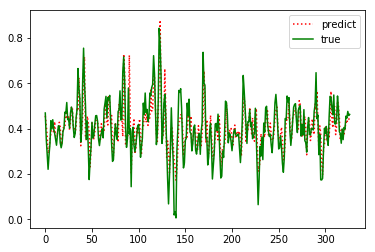

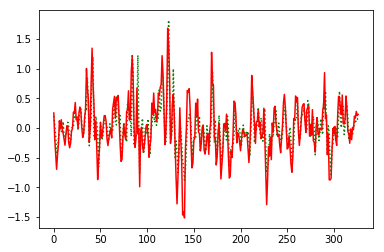

In [18]:
predict_y, test_y, model = train_model(train_x, train_y, test_x, test_y)
predict_y = scaler.inverse_transform([[i] for i in predict_y])
test_y = scaler.inverse_transform(test_y)
fig2 = plt.figure(2)
plt.plot(predict_y, 'g:')
plt.plot(test_y, 'r-')
plt.show()


In [19]:
trend_list = [1,]
for i in range(1, len(predict_y)):
    if predict_y[i] <= quantile033:
        trend_list.append(-1)
    elif quantile033 <= predict_y[i] <= quantile067:
        trend_list.append(0)
    else:
        trend_list.append(1)

real_trend_list = [1,]
for i in range(1, len(test_y)):
    if test_y[i] <= quantile033:
        real_trend_list.append(-1)
    elif quantile033 <= test_y[i] <= quantile067:
        real_trend_list.append(0)
    else:
        real_trend_list.append(1)
        
#     if ave_change < quantile033:
#         trend_column.append(-1)
#     elif quantile033 <= ave_change <= quantile067:
#         trend_column.append(0)
#     else:
#         trend_column.append(1)

true_count = 0
false_count = 0


print(len(test_y), len(predict_y))

pair_list = []

for i in range(len(predict_y)-1):
    pair_list.append([real_trend_list[i], trend_list[i]])
    if real_trend_list[i] == trend_list[i]:
        true_count = true_count + 1
    else:
        false_count = false_count + 1

# print(pair_list)
print(true_count, false_count)


327 327
217 109


In [20]:
len(real_trend_list) , len(trend_list)

(327, 327)

In [21]:
accuracy = true_count/ len(predict_y)
accuracy

0.6636085626911316

In [22]:
from collections import Counter

result = Counter(trend_list)
print ("预测数据", result)
result = Counter(real_trend_list)
print ("真实数据", result)

预测数据 Counter({1: 118, -1: 117, 0: 92})
真实数据 Counter({-1: 135, 1: 126, 0: 66})


In [23]:
# count = 0
# for i in predict_y:
#     if quantile033 < i < quantile067:
#         count += 1

# print(count)

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 10)          1200      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 10)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               168800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 170,201
Trainable params: 170,201
Non-trainable params: 0
_________________________________________________________________


In [25]:
real_df = pd.DataFrame(real_trend_list)
pred_df = pd.DataFrame(trend_list)
acc_df = pd.concat((real_df[0],pred_df[0]), axis=1)
acc_df

,0,0
0,1,1
1,-1,0
2,-1,-1
3,-1,-1
4,-1,-1
5,-1,-1
6,1,0
7,0,0
8,1,0
9,0,0


In [43]:
temp_list = []
temp_df =  real_df[0] - pred_df[0]
for i in range(0, len(temp_df)):
    temp_list.append([i, temp_df[i]])

In [45]:
%matplotlib qt
plt.clf()
plt.figure()
plt.scatter( *zip(*temp_list), )
# plt.scatter(real_df.index.values, pred_df[0],color='blue', marker='^')
# plt.scatter(real_df.index.values, real_df[0],color='red', marker='.')
plt.title('Trend Prediction Accuracy of individual+macro index model = {}'.format(accuracy))
plt.xlabel('Days')
plt.ylabel('Trend Prediction')
plt.show()

In [46]:
%matplotlib qt
plt.clf()
fig2 = plt.figure()
plt.plot(predict_y, 'b-',label = 'predict ave change')
plt.plot(test_y, 'r-', label = 'true ave change')
plt.title('individual+macro index model change price prediction')
plt.xlabel('Days')
plt.ylabel('change price')
plt.legend()
plt.show()

In [26]:
df.shape, input_data.shape

((1645, 11), (1645, 19))

In [28]:
input_data.columns, df.columns

(Index(['open_x', 'high_x', 'low_x', 'close_x', 'pre_close_x', 'change_x',
        'pct_chg_x', 'vol_x', 'amount_x', 'close_y', 'open_y', 'high_y',
        'low_y', 'pre_close_y', 'change_y', 'pct_chg_y', 'vol_y', 'amount_y',
        'ave_change'],
       dtype='object'),
 Index(['ts_code', 'trade_date', 'open', 'high', 'low', 'close', 'pre_close',
        'change', 'pct_chg', 'vol', 'amount'],
       dtype='object'))

In [29]:
new_data = input_data.copy()
new_data[['ts_code', 'trade_date']] = df[['ts_code', 'trade_date' ]]

In [31]:
cols = new_data.columns.tolist()
cols

['open_x',
 'high_x',
 'low_x',
 'close_x',
 'pre_close_x',
 'change_x',
 'pct_chg_x',
 'vol_x',
 'amount_x',
 'close_y',
 'open_y',
 'high_y',
 'low_y',
 'pre_close_y',
 'change_y',
 'pct_chg_y',
 'vol_y',
 'amount_y',
 'ave_change',
 'ts_code',
 'trade_date']

In [32]:
new_data.head()

,open_x,high_x,low_x,close_x,pre_close_x,change_x,pct_chg_x,vol_x,amount_x,close_y,...,high_y,low_y,pre_close_y,change_y,pct_chg_y,vol_y,amount_y,ave_change,ts_code,trade_date
0,8.43,8.81,8.40,8.68,8.45,0.23,2.72,1277998.67,1.105772e+06,2759.362,...,2778.668,2752.966,2762.076,-2.714,-0.0983,92072878.0,1.054532e+08,0.046667,000002.SZ,20110701
1,8.73,8.97,8.68,8.71,8.68,0.03,0.35,832629.39,7.328196e+05,2812.818,...,2813.270,2770.940,2759.362,53.456,1.9373,121962260.0,1.438187e+08,0.020000,000002.SZ,20110704
2,8.71,9.02,8.71,8.84,8.71,0.13,1.49,1470530.64,1.307364e+06,2816.355,...,2818.141,2799.110,2812.818,3.537,0.1257,110124224.0,1.286545e+08,-0.006667,000002.SZ,20110705
3,8.85,8.88,8.71,8.82,8.84,-0.02,-0.23,609540.69,5.355945e+05,2810.479,...,2811.815,2780.728,2816.355,-5.876,-0.2086,103104393.0,1.220889e+08,-0.023333,000002.SZ,20110706
4,8.84,8.98,8.55,8.77,8.82,-0.05,-0.57,846650.10,7.444219e+05,2794.267,...,2825.123,2793.892,2810.479,-16.212,-0.5768,116512143.0,1.400651e+08,-0.090000,000002.SZ,20110707


In [33]:
new_data = new_data.reindex_axis(['ts_code','trade_date','open_x','high_x','low_x','close_x','pre_close_x','change_x','pct_chg_x','vol_x','amount_x','close_y','open_y','high_y','low_y',
 'pre_close_y','change_y','pct_chg_y','vol_y','amount_y','ave_change'], axis=1)
new_data.head()


d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  


,ts_code,trade_date,open_x,high_x,low_x,close_x,pre_close_x,change_x,pct_chg_x,vol_x,...,close_y,open_y,high_y,low_y,pre_close_y,change_y,pct_chg_y,vol_y,amount_y,ave_change
0,000002.SZ,20110701,8.43,8.81,8.40,8.68,8.45,0.23,2.72,1277998.67,...,2759.362,2767.834,2778.668,2752.966,2762.076,-2.714,-0.0983,92072878.0,1.054532e+08,0.046667
1,000002.SZ,20110704,8.73,8.97,8.68,8.71,8.68,0.03,0.35,832629.39,...,2812.818,2770.940,2813.270,2770.940,2759.362,53.456,1.9373,121962260.0,1.438187e+08,0.020000
2,000002.SZ,20110705,8.71,9.02,8.71,8.84,8.71,0.13,1.49,1470530.64,...,2816.355,2812.722,2818.141,2799.110,2812.818,3.537,0.1257,110124224.0,1.286545e+08,-0.006667
3,000002.SZ,20110706,8.85,8.88,8.71,8.82,8.84,-0.02,-0.23,609540.69,...,2810.479,2811.815,2811.815,2780.728,2816.355,-5.876,-0.2086,103104393.0,1.220889e+08,-0.023333
4,000002.SZ,20110707,8.84,8.98,8.55,8.77,8.82,-0.05,-0.57,846650.10,...,2794.267,2813.193,2825.123,2793.892,2810.479,-16.212,-0.5768,116512143.0,1.400651e+08,-0.090000


In [34]:
new_data.shape

(1645, 21)

In [35]:
train_x.shape, test_x.shape

((1307, 10, 19), (327, 10, 19))

In [36]:
new_data['ave_change'].iloc[1317:].head(20)

1317    0.253333
1318   -0.173333
1319   -0.446667
1320   -0.696667
1321   -0.453333
1322   -0.266667
1323    0.123333
1324   -0.016667
1325    0.140000
1326   -0.016667
1327   -0.086667
1328   -0.193333
1329   -0.290000
1330   -0.113333
1331    0.036667
1332    0.030000
1333   -0.250000
1334   -0.333333
1335   -0.260000
1336   -0.053333
Name: ave_change, dtype: float64

In [37]:
test_y[0:20] , predict_y[0:5]

(array([[ 0.25333333],
        [-0.17333333],
        [-0.44666667],
        [-0.69666667],
        [-0.45333333],
        [-0.26666667],
        [ 0.12333333],
        [-0.01666667],
        [ 0.14      ],
        [-0.01666667],
        [-0.08666667],
        [-0.19333333],
        [-0.29      ],
        [-0.11333333],
        [ 0.03666667],
        [ 0.03      ],
        [-0.25      ],
        [-0.33333333],
        [-0.26      ],
        [-0.05333333]]), array([[ 0.20495024],
        [ 0.0532194 ],
        [-0.13465078],
        [-0.42758882],
        [-0.38244268]]))

In [38]:
save_data = new_data[1317:-1]

In [39]:
save_data.shape , test_x.shape, predict_y.shape , len(trend_list), len(real_trend_list)

((327, 21), (327, 10, 19), (327, 1), 327, 327)

In [40]:
save_data['pred_ave_change'] = predict_y
save_data['real_trend'] = real_trend_list
save_data['pred_trend'] = trend_list

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [41]:
save_data.head()

,ts_code,trade_date,open_x,high_x,low_x,close_x,pre_close_x,change_x,pct_chg_x,vol_x,...,low_y,pre_close_y,change_y,pct_chg_y,vol_y,amount_y,ave_change,pred_ave_change,real_trend,pred_trend
1317,000002.SZ,20170714,24.45,24.83,24.36,24.59,24.43,0.16,0.65,201797.31,...,3204.8529,3218.1632,4.2536,0.1322,160126773.0,174312138.1,0.253333,0.204950,1,1
1318,000002.SZ,20170718,25.58,25.80,24.88,25.30,24.59,0.71,2.89,791833.77,...,3150.1284,3176.4648,11.1024,0.3495,190623060.0,196452361.5,-0.173333,0.053219,-1,0
1319,000002.SZ,20170719,24.85,26.06,24.43,25.14,25.30,-0.16,-0.63,1008070.70,...,3179.7300,3187.5672,43.4090,1.3618,272420726.0,269771019.5,-0.446667,-0.134651,-1,-1
1320,000002.SZ,20170720,24.85,25.64,24.73,25.35,25.14,0.21,0.84,633677.05,...,3225.4328,3230.9762,13.8885,0.4299,232108392.0,245825421.9,-0.696667,-0.427589,-1,-1
1321,000002.SZ,20170721,25.19,25.64,24.65,24.78,25.35,-0.57,-2.25,477662.55,...,3231.9556,3244.8647,-6.8830,-0.2121,206003251.0,221956909.9,-0.453333,-0.382443,-1,-1


In [42]:
save_data.to_csv('3-Result-Vanke-from-20110701-to-20181118.csv', index=True)